In [1]:
'''
Created on July 9, 2018

@author Alex Yu
@version July 9, 2018
'''
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
from scipy.stats import linregress   
import warnings; warnings.simplefilter('ignore')

pd.options.mode.chained_assignment = None  # default='warn'

plt.style.use('fivethirtyeight')

# Exp 

In [5]:
gen_info = pd.read_table('LifeSpanCellFeatures/exp56_changhui.txt', sep='\t')
gen_info.sort_values(by=['pos', 'label', 'time'], ascending=True, inplace=True)

gen_info['state_int'] = 0
gen_info['state_int'][gen_info['state']=='S'] = 1
gen_info.drop(['x', 'y', 'auto_type', 'final_state', 'is_fresh'], axis=1, inplace=True)
gen_info['gen'] = gen_info.groupby(by=['pos', 'label']).state_int.cumsum() + 1
gen_info['id'] = 'P' + gen_info['pos'].astype(str) + 'L' + gen_info['label'].astype(str)
gen_info['min'] = 30 * gen_info['time']

gen_info['area_change'] = gen_info.groupby(by=['pos', 'label'])['area'].apply(lambda x: x.div(x.iloc[0])).multiply(100)
mean_data = gen_info.groupby(by='gen')['area_change'].mean().reset_index()
data_vals = gen_info.pivot_table(index = 'id', columns = 'gen', values = 'area_change')
std_vals = data_vals.std(axis=0)
std_vals.reset_index(drop=True, inplace=True)

lifespans = gen_info.groupby(by=['pos', 'label'])['min'].max().reset_index().sort_values(by=['min'], ascending=False)
lifespans.rename(columns={'min':'lifespan'}, inplace=True)
#lifespans

In [6]:
before_last_gen =  gen_info.groupby(by=['pos', 'label']).apply(lambda x: x[x['gen'] < x['gen'].max()])
before_last_gen.drop(['pos', 'label'], axis=1, inplace=True)

after_last_gen = gen_info.groupby(by=['pos', 'label']).apply(lambda x: x[x['gen'] >= x['gen'].max()])
mean_after_size = int(after_last_gen.groupby(by=['pos', 'label']).size().mean())
after_last_gen = after_last_gen.groupby(by=['pos', 'label']).filter(lambda x: len(x) >= mean_after_size)
after_last_gen.drop(['pos', 'label'], axis=1, inplace=True)

blg_lin = (before_last_gen.groupby(by=['pos', 'label']).apply(lambda x: pd.Series(linregress(x['min'], x['area'])))
               .rename(columns={
                        0: 'pre-slope',
                        1: 'pre-intercept',
                        2: 'pre-rvalue',
                        3: 'pre-pvalue',
                        4: 'pre-stderr'
                      })
       )

alg_lin = (after_last_gen.groupby(by=['pos', 'label']).apply(lambda x: pd.Series(linregress(x['min'], x['area'])))
               .rename(columns={
                        0: 'post-slope',
                        1: 'post-intercept',
                        2: 'post-rvalue',
                        3: 'post-pvalue',
                        4: 'post-stderr'
                      })
       )

lin_data = pd.merge(blg_lin, alg_lin, on=['pos', 'label'], how='outer')
lin_data = lin_data.dropna(axis=0)

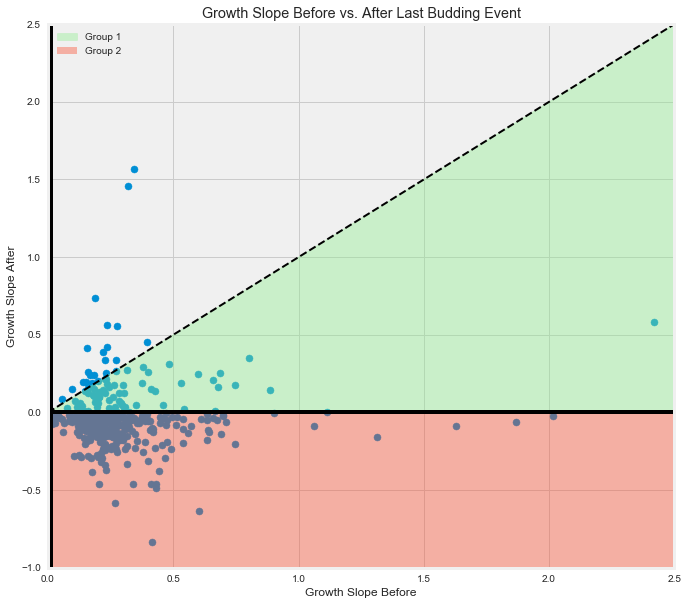

In [96]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(lin_data['pre-slope'], lin_data['post-slope'], label = '_nolegend_')
plt.xlabel('Growth Slope Before')
plt.ylabel('Growth Slope After')
plt.title('Growth Slope Before vs. After Last Budding Event')

plt.xlim(xmin=0, xmax=2.5)
plt.ylim(ymin=-1, ymax=2.5)

ax.axhline(y=0, color='k')
ax.axvline(x=0.01, color='k')

ax.plot([0, 3], [0, 3], color='k', linestyle='--', linewidth = 2)

plt.fill_between([0, 3], [0, 3], alpha = .4, color = 'lightgreen', label = 'Group 1')
plt.fill_between([0, 3], [-3, -3], alpha = .4, label = 'Group 2')

plt.legend()

In [78]:
group1 = lin_data[(lin_data['pre-slope'] > lin_data['post-slope']) & (lin_data['post-slope']>0)].reset_index()
group1 = group1.drop(['pre-intercept', 'pre-pvalue', 'pre-stderr', 'post-intercept', 'post-pvalue', 'post-stderr'], axis=1)
group1 = pd.merge(group1, gen_info.groupby(by=['pos', 'label']).gen.max().reset_index())
group1 = pd.merge(group1, gen_info.groupby(by=['pos', 'label']).area.first().reset_index())
group1 = group1.rename(columns={'gen':'total_gens', 'area':'initial_area'})
group1['slope_div'] = group1['pre-slope'] / group1['post-slope']


Text(0.5,1,'Distribution of Lifespan Where Pre-Slope > Post-Slope and Post-Slope > 0')

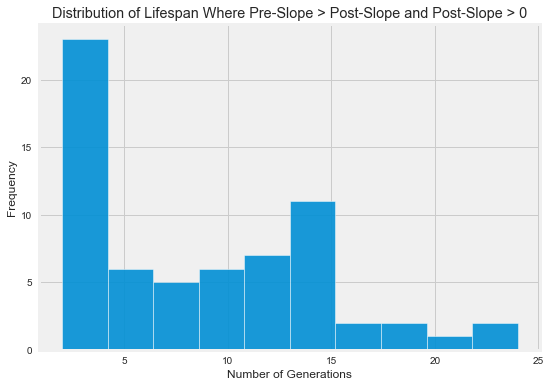

In [97]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(x=group1['total_gens'], bins = 10, ec='white', alpha=.9)

plt.xlabel('Number of Generations')
plt.ylabel('Frequency')
plt.title('Distribution of Lifespan Where Pre-Slope > Post-Slope and Post-Slope > 0')


In [75]:
group2 = lin_data[(lin_data['pre-slope'] > lin_data['post-slope']) & (lin_data['post-slope'] < 0)].reset_index()
group2 = group2.drop(['pre-intercept', 'pre-pvalue', 'pre-stderr', 'post-intercept', 'post-pvalue', 'post-stderr'], axis=1)
group2 = pd.merge(group2, gen_info.groupby(by=['pos', 'label']).gen.max().reset_index())
group2 = pd.merge(group2, gen_info.groupby(by=['pos', 'label']).area.first().reset_index())
group2 = group2.rename(columns={'gen':'total_gens', 'area':'initial_area'})
group2['slope_div'] = group2['pre-slope'] / group2['post-slope']


Text(0.5,1,'Distribution of Lifespan Where Pre-Slope < Post-Slope and Post-Slope < 0')

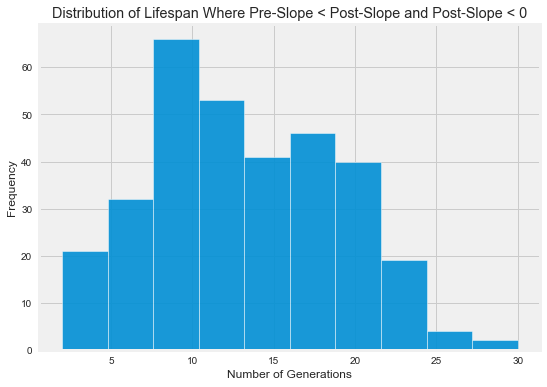

In [77]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(x=group2['total_gens'], bins = 10, ec='white', alpha=.9)

plt.xlabel('Number of Generations')
plt.ylabel('Frequency')
plt.title('Distribution of Lifespan Where Pre-Slope < Post-Slope and Post-Slope < 0')


In [98]:
lin_data[(lin_data['post-slope'] > 1.0) & (lin_data['pre-slope'] > 0)]

,,pre-slope,pre-intercept,pre-rvalue,pre-pvalue,pre-stderr,post-slope,post-intercept,post-rvalue,post-pvalue,post-stderr
pos,label,,,,,,,,,,
638,23,0.344117,468.375302,0.536173,1.442302e-06,0.065219,1.564901,-3324.708149,0.857471,4.839066e-16,0.132799
754,68,0.319869,582.803717,0.896852,9.393871e-16,0.024944,1.456872,-182.441833,0.546147,1.210032e-06,0.272997


In [100]:
gen_info[(gen_info['pos']==754) & (gen_info['label']==68)]

,pos,label,time,area,state,state_int,gen,id,min,area_change
183614,754,68,1,580.0,S,1,2,P754L68,30,100.000000
183615,754,68,2,665.0,P,0,2,P754L68,60,114.655172
183616,754,68,3,594.0,S,1,3,P754L68,90,102.413793
183617,754,68,4,694.0,P,0,3,P754L68,120,119.655172
183618,754,68,5,650.0,P,0,3,P754L68,150,112.068966
183619,754,68,6,596.0,S,1,4,P754L68,180,102.758621
183620,754,68,7,641.0,P,0,4,P754L68,210,110.517241
183621,754,68,8,598.0,S,1,5,P754L68,240,103.103448
183622,754,68,9,625.0,P,0,5,P754L68,270,107.758621
183623,754,68,10,685.0,S,1,6,P754L68,300,118.103448
